<a href="https://colab.research.google.com/github/Ayush-mishra-0-0/cn-assign/blob/main/GNN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ayush Patel
#12240350

## Both task are solved at tthe bottom cells

In [2]:
%%capture
url = 'https://data.pyg.org/whl/torch-2.0.0+cpu.html'
!pip install torch-scatter -f $url
!pip install torch-sparse -f $url
!pip install torch-geometric
!pip install torch-cluster -f $url
!pip install --upgrade scipy

In [ ]:
%%capture
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from collections import Counter
import torch

In [ ]:
def make_deterministic(random_seed = 123):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

make_deterministic()

# Data Handling

#### Pytorch Geometric (PyG) - Graph Data Object
A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyG is described by an instance of torch_geometric.data.Data, which holds the following attributes by default:

data.x: Node feature matrix with shape [num_nodes, num_node_features]

data.edge_index: Graph connectivity in COO (coordinate list) format with shape [2, num_edges] and type torch.long

data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

data.pos: Node position matrix with shape [num_nodes, num_dimensions]

None of these attributes are required. In fact, the Data object is not even restricted to these attributes. We can, e.g., extend it by data.face to save the connectivity of triangles from a 3D mesh in a tensor with shape [3, num_faces] and type torch.long.



In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0,  1, 0, 3, 4],
                           [1,  2, 2, 0, 3]], dtype=torch.long)
x = torch.tensor([[-1, 0, 1], [0, 2, 3], [1, 2, 1], [1, -2, 1], [1, 2, -1]], dtype=torch.float)
y = torch.tensor([[1], [0], [0], [1], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index, y=y)

data

Data(x=[5, 3], edge_index=[2, 5], y=[5, 1])

In [ ]:
print("Features: ", data['x'])

print('Number of nodes: ', data.num_nodes)

print('Number of edges:', data.num_edges)

print('Number of node features:', data.num_node_features)

print('Any isolated nodes:', data.has_isolated_nodes())

print('Any self-loop',  data.has_self_loops())

print('Directed or Not', data.is_directed())

print('Label', data.y)

Features:  tensor([[-1.,  0.,  1.],
        [ 0.,  2.,  3.],
        [ 1.,  2.,  1.],
        [ 1., -2.,  1.],
        [ 1.,  2., -1.]])
Number of nodes:  5
Number of edges: 5
Number of node features: 3
Any isolated nodes: False
Any self-loop False
Directed or Not True
Label tensor([[1.],
        [0.],
        [0.],
        [1.],
        [1.]])


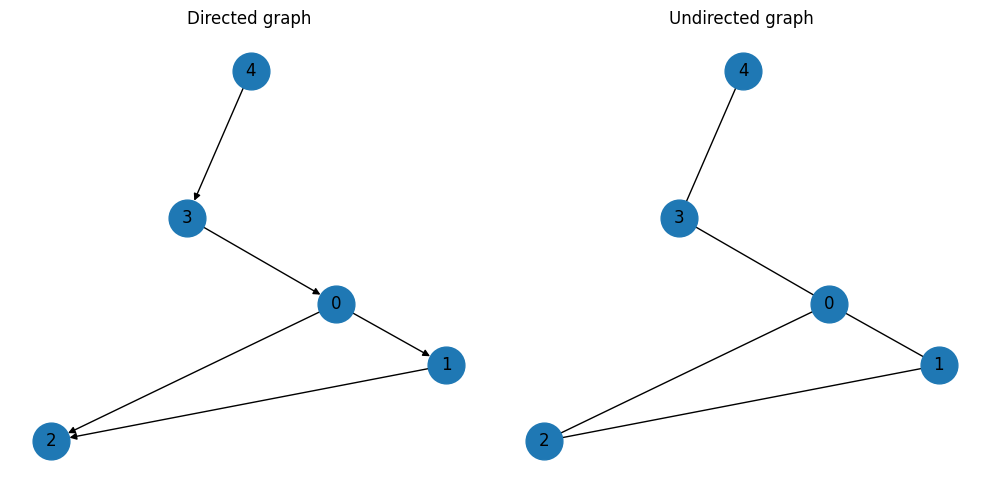

In [ ]:
G1 = to_networkx(data, to_undirected=False)
G2 = to_networkx(data, to_undirected=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Use a fixed layout so the graphs look identical
pos = nx.spring_layout(G1, seed=42)

# Plot the first graph
nx.draw(G1, pos, with_labels=True, node_size=700, edge_color='black', ax=axes[0])
axes[0].set_title("Directed graph")

# Plot the second graph (identical)
nx.draw(G2, pos, with_labels=True, node_size=700, edge_color='black', ax=axes[1])
axes[1].set_title("Undirected graph")

plt.tight_layout()
plt.show()

# 1. Loading Data
We are using [Cora dataset](https://paperswithcode.com/dataset/cora) for the following GCN implementations. The Cora dataset is a paper citation network data that consists of 2,708 scientific publications. Each node in the graph represents each publication and a pair of nodes is connected with an edge if one paper cites the other.

Through this notebook, we are using [PyG (Pytorch Geometric)](https://www.pyg.org/) to implement GCN which is one of the popular GNN libraries. The Cora dataset can also be loaded using PyG module.

In [ ]:
%%capture

from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [ ]:
def show_dataset_stats(dataset):
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of node classes: {dataset.num_classes}")
    print(f"Number of node features: {dataset.num_node_features}")

show_dataset_stats(dataset)

Number of graphs: 1
Number of node classes: 7
Number of node features: 1433


In [ ]:
def show_graph_stats(graph):
    print(f"Number of nodes: {graph.x.shape[0]}")
    print(f"Number of node features: {graph.x.shape[1]}")
    print(f"Number of edges: {graph.edge_index.shape[1]}")

graph = dataset[0]
show_graph_stats(graph)

Number of nodes: 2708
Number of node features: 1433
Number of edges: 10556


The node features and the edge information look like below. The node features are 1433 word vectors indicating the absence (0) or the presence (1) of the words in each publication. The edges are represented in adjacency lists.

In [ ]:
graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
graph.edge_index

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

In [ ]:
graph.edge_index.T

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

Each node has one of seven classes which is going to be our model target/label.

In [ ]:
"""
Class Definition
0: Theory
1: Reinforcement_Learning
2: Genetic_Algorithms
3: Neural_Networks
4: Probabilistic_Methods
5: Case_Based
6: Rule_Learning
"""

print("Class Distribution:")
sorted(Counter(graph.y.tolist()).items())

Class Distribution:


[(0, 351), (1, 217), (2, 418), (3, 818), (4, 426), (5, 298), (6, 180)]

## Visualizing Graph
The graph data can be visualized using [NetworkX](https://networkx.org/) library. The node colors represent the node classes.

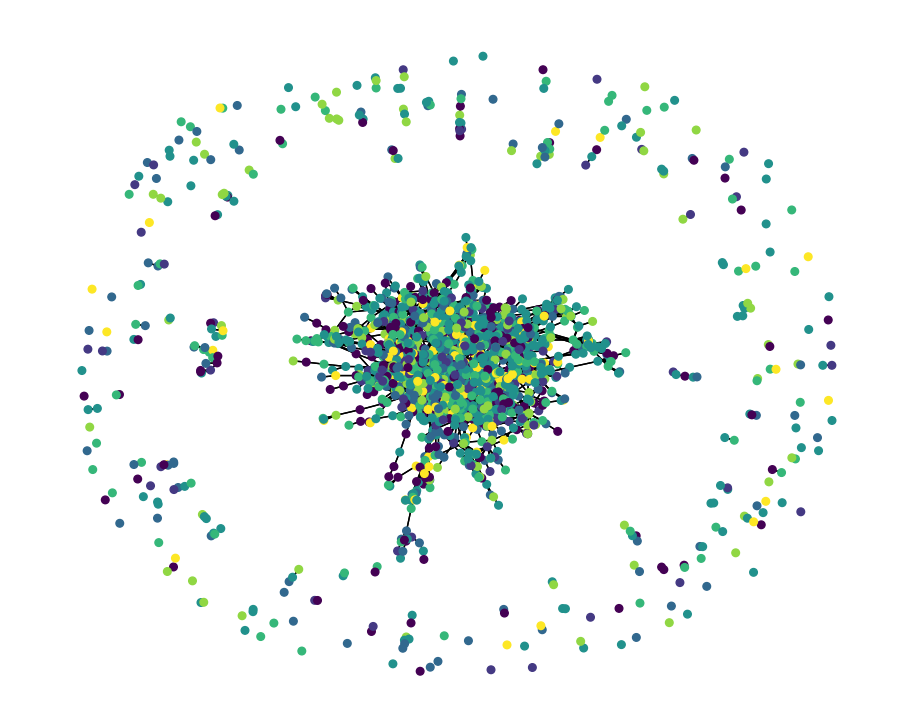

In [ ]:
def convert_to_networkx(graph, n_sample=None):
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(list(g.nodes), n_sample)  # Convert g.nodes to a list
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y

def plot_graph(g, y):
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show()

# Example usage:
g, y = convert_to_networkx(graph, n_sample=2000)
plot_graph(g, y)

## Node Classification

For the node classification problem, we are splitting the nodes into train, valid, and test using the `RandomNodeSplit` module from PyG (we are replacing the original split masks in the data as it has a too small train set).

In [ ]:
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)  # resetting data split
print(
    f"train: {int(graph.train_mask.sum())}, ",
    f"val: {int(graph.val_mask.sum())}, ",
    f"test: {int(graph.test_mask.sum())}",
)

train: 1895,  val: 271,  test: 542


In [ ]:
graph.test_mask

tensor([False, False,  True,  ..., False, False, False])

Please note the data splits are written into `mask` attributes in the graph object instead of splitting the graph itself. Those masks are only used for training loss calculation and model evaluation, and graph convolutions use entire graph data.

## 2-1. Baseline MLP model
Before we build GCN, we are training MLP (multi-layer perceptron, i.e. feed-forward neural nets) only using node features to set a baseline performance. The model ignores the node connections (or the graph structure) and tries to classify the node labels only using the word vectors. The model class looks like below. It has two hidden layers (`Linear`) with ReLU activations followed by an output layer.

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

We are defining training and evaluation functions with a normal Pytorch train/eval setup.

In [ ]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph = graph.to(device)
mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)

Epoch: 010, Train Loss: 0.770, Val Acc: 0.694
Epoch: 020, Train Loss: 0.089, Val Acc: 0.727
Epoch: 030, Train Loss: 0.018, Val Acc: 0.716
Epoch: 040, Train Loss: 0.012, Val Acc: 0.720
Epoch: 050, Train Loss: 0.015, Val Acc: 0.753
Epoch: 060, Train Loss: 0.013, Val Acc: 0.745
Epoch: 070, Train Loss: 0.011, Val Acc: 0.749
Epoch: 080, Train Loss: 0.010, Val Acc: 0.734
Epoch: 090, Train Loss: 0.009, Val Acc: 0.731
Epoch: 100, Train Loss: 0.009, Val Acc: 0.734
Epoch: 110, Train Loss: 0.008, Val Acc: 0.742
Epoch: 120, Train Loss: 0.008, Val Acc: 0.742
Epoch: 130, Train Loss: 0.008, Val Acc: 0.731
Epoch: 140, Train Loss: 0.007, Val Acc: 0.731
Epoch: 150, Train Loss: 0.007, Val Acc: 0.723


In [ ]:
test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Test Acc: 0.732


## 2-2. GCN
Next, we are training GCN and comparing its performance to MLP. We are using a very simple model having two graph convolution layers and ReLU activation between them. This setup is the same as [the original paper](https://arxiv.org/pdf/1609.02907.pdf) (equation 9).

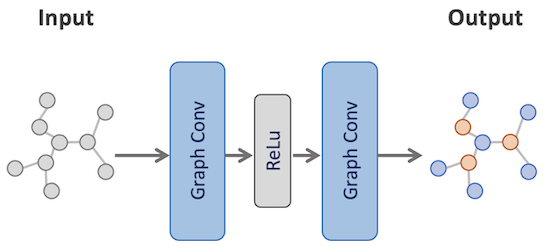

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

In [ ]:
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

Epoch: 010, Train Loss: 1.017, Val Acc: 0.790
Epoch: 020, Train Loss: 0.411, Val Acc: 0.889
Epoch: 030, Train Loss: 0.240, Val Acc: 0.897
Epoch: 040, Train Loss: 0.178, Val Acc: 0.900
Epoch: 050, Train Loss: 0.149, Val Acc: 0.889
Epoch: 060, Train Loss: 0.135, Val Acc: 0.893
Epoch: 070, Train Loss: 0.126, Val Acc: 0.886
Epoch: 080, Train Loss: 0.117, Val Acc: 0.886
Epoch: 090, Train Loss: 0.110, Val Acc: 0.886
Epoch: 100, Train Loss: 0.103, Val Acc: 0.886
Epoch: 110, Train Loss: 0.097, Val Acc: 0.882
Epoch: 120, Train Loss: 0.092, Val Acc: 0.882
Epoch: 130, Train Loss: 0.088, Val Acc: 0.878
Epoch: 140, Train Loss: 0.085, Val Acc: 0.875
Epoch: 150, Train Loss: 0.081, Val Acc: 0.875
Epoch: 160, Train Loss: 0.079, Val Acc: 0.875
Epoch: 170, Train Loss: 0.076, Val Acc: 0.878
Epoch: 180, Train Loss: 0.074, Val Acc: 0.878
Epoch: 190, Train Loss: 0.072, Val Acc: 0.878
Epoch: 200, Train Loss: 0.070, Val Acc: 0.878


In [ ]:
test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Test Acc: 0.880


We achieved around 15% accuracy improvement from MLP.

### Visualizing classification result

yellow node: correct 
purple node: wrong


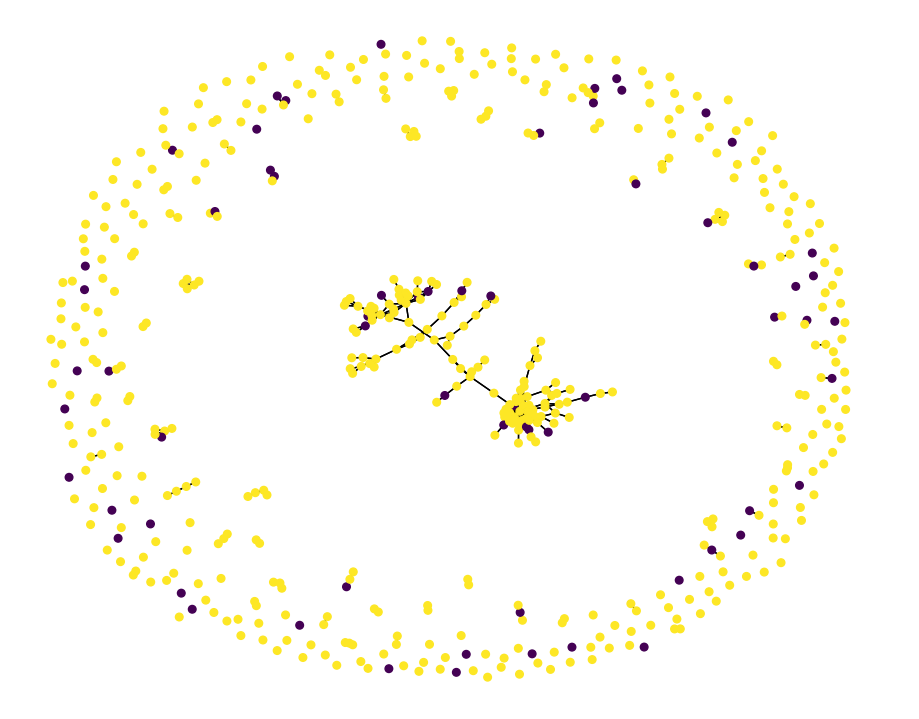

In [ ]:
def visualize_classification_result(model, graph):
    model.eval()
    pred = model(graph).argmax(dim=1)
    corrects = (pred[graph.test_mask] == graph.y[graph.test_mask]).cpu().numpy().astype(int)  # Move to CPU before converting to NumPy
    test_index = np.arange(len(graph.x))[graph.test_mask.cpu().numpy()]  # Move test_mask to CPU
    g, y = convert_to_networkx(graph)
    g_test = g.subgraph(test_index)

    print("yellow node: correct \npurple node: wrong")
    plot_graph(g_test, corrects)

# Example usage:
visualize_classification_result(gcn, graph)

Using Barabasi Network

In [ ]:

num_nodes = 200
m_edges = 3
G = nx.barabasi_albert_graph(num_nodes, m_edges)

In [ ]:
# Handcraft features
# Compute node features: degree, betweenness, closeness, clustering
degree = dict(G.degree())
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
clustering = nx.clustering(G)

features = np.array([
    [degree[node], betweenness[node], closeness[node], clustering[node]]
    for node in G.nodes()
], dtype=np.float32)

In [ ]:
features[0:2]

array([[4.7000000e+01, 1.9719030e-01, 5.1958227e-01, 4.6253469e-02],
       [4.4000000e+01, 2.1184754e-01, 5.3351206e-01, 4.0169135e-02]],
      dtype=float32)

In [ ]:
# Normalize features
features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-6)
features[0:2]

array([[ 6.901062  ,  7.6300817 ,  4.2361417 , -0.34226835],
       [ 6.3972125 ,  8.224968  ,  4.601862  , -0.38140664]],
      dtype=float32)

In [ ]:
#Define Labels (Binary Classification)
labels = np.array([1 if degree[node] > 3 else 0 for node in G.nodes()], dtype=np.int64)

In [ ]:
labels

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [ ]:
# Convert features and labels to tensors
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

In [ ]:
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
edge_index

tensor([[  0,   0,   0,  ..., 184, 185, 187],
        [  1,   2,   3,  ..., 198, 193, 190]])

In [ ]:
# Convert to PyG Graph
graph_data = Data(x=x, edge_index=edge_index, y=y)
graph_data

Data(x=[200, 4], edge_index=[2, 591], y=[200])

In [ ]:
# Apply RandomNodeSplit transform to create train/val/test masks
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph_data = split(graph_data)

print("Split sizes:")
print(f"Train: {int(graph_data.train_mask.sum())}")
print(f"Val:   {int(graph_data.val_mask.sum())}")
print(f"Test:  {int(graph_data.test_mask.sum())}")


Split sizes:
Train: 140
Val:   20
Test:  40


In [ ]:
 #Define GCN Model

class GCN_BA(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 10)
        self.mlp = torch.nn.Linear(10, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.mlp(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN_BA(in_channels=4, hidden_channels=16, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

graph_data = graph_data.to(device)


In [ ]:
 #Train the Model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])

    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f}")

Epoch 000 | Loss: 0.7120
Epoch 020 | Loss: 0.6255
Epoch 040 | Loss: 0.6045
Epoch 060 | Loss: 0.5800
Epoch 080 | Loss: 0.5550
Epoch 100 | Loss: 0.5389
Epoch 120 | Loss: 0.5241
Epoch 140 | Loss: 0.5201
Epoch 160 | Loss: 0.4979
Epoch 180 | Loss: 0.4852


In [ ]:
# Evaluate the Model
model.eval()
out = model(graph_data.x, graph_data.edge_index)
pred = out.argmax(dim=1)

correct = (pred[graph_data.test_mask] == graph_data.y[graph_data.test_mask]).sum()
acc = correct / graph_data.test_mask.sum()
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.6750


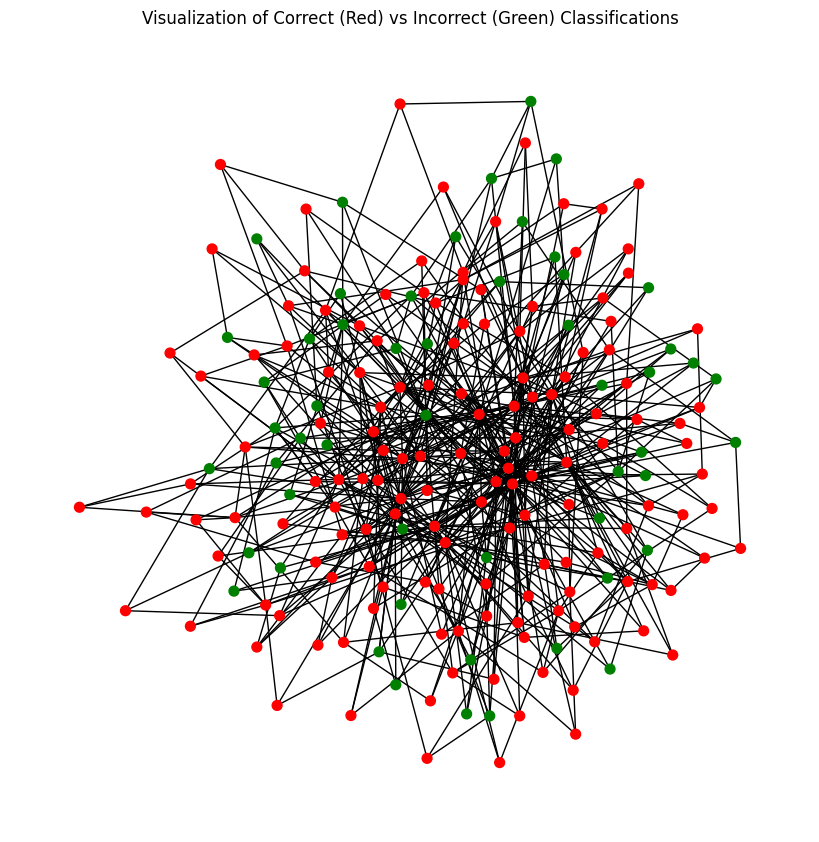

In [ ]:
# Identify misclassified nodes
incorrect_nodes = (pred != graph_data.y).cpu().numpy()  # Boolean array
correct_nodes = ~incorrect_nodes  # Opposite of incorrect_nodes

#  Visualization: Correct vs Incorrect Classifications
plt.figure(figsize=(8, 8))

# Node colors:
# - Green for correctly classified
# - Red for incorrectly classified
color_map = ['Red' if correct_nodes[i] else 'Green' for i in range(num_nodes)]

# Draw the graph
nx.draw(G, node_color=color_map, with_labels=False, node_size=50)

# Add title
plt.title("Visualization of Correct (Red) vs Incorrect (Green) Classifications")
plt.show()


#Task 1
 Apply GraphSAGE model and compare the results on cora dataset and Barabasi network.


# 📊 GraphSAGE Model Comparison: Cora vs. Barabási-Albert Networks

## 🧠 Introduction

This notebook compares the performance of **GraphSAGE** on two different graph structures:

- 📚 The **Cora citation network** (real-world dataset)
- 🧪 A synthetic **Barabási-Albert network** with similar dimensions

We'll analyze:
- 🔢 Network statistics
- 📉 Degree distributions
- 🤖 Model performance

The objective is to understand how **graph structure** affects **GraphSAGE's classification ability**.

---

## ⚙️ Setup and Imports


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from IPython.display import HTML, display
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Styled printing function
def print_header(text):
    display(HTML(f"<h3 style='color:#4285F4;'>{text}</h3>"))

def print_subheader(text):
    display(HTML(f"<h4 style='color:#0F9D58;'>{text}</h4>"))

def print_info(text):
    display(HTML(f"<p style='color:#DB4437;'>{text}</p>"))

def print_success(text):
    display(HTML(f"<p style='color:#0F9D58;'>{text}</p>"))

def print_warning(text):
    display(HTML(f"<p style='color:#F4B400;'>{text}</p>"))

def print_table(data_dict):
    """Create a styled HTML table from a dictionary"""
    html = "<table style='width:100%; border-collapse:collapse; margin:10px 0'>"

    # Header row
    html += "<tr style='background-color:#4285F4; color:white'>"
    for key in data_dict.keys():
        html += f"<th style='padding:10px; text-align:left; border:1px solid #ddd'>{key}</th>"
    html += "</tr>"

    # Data rows
    for i in range(len(list(data_dict.values())[0])):
        html += "<tr style='background-color:" + ('#f2f2f2' if i % 2 else 'white') + "'>"
        for key in data_dict.keys():
            val = data_dict[key][i]
            if isinstance(val, float):
                html += f"<td style='padding:10px; border:1px solid #ddd'>{val:.4f}</td>"
            else:
                html += f"<td style='padding:10px; border:1px solid #ddd'>{val}</td>"
        html += "</tr>"

    html += "</table>"
    display(HTML(html))

## 🧩 GraphSAGE Model Definition

**GraphSAGE** (Graph SAmple and aggreGatE) is a powerful **graph neural network** architecture that learns **node embeddings** by **sampling** and **aggregating** features from local neighborhoods.

Instead of using the full graph structure, GraphSAGE:
- Samples a fixed-size neighborhood for each node
- Aggregates feature information (e.g., mean, LSTM, or pooling)
- Updates the node representation based on the aggregated neighborhood features

This makes it efficient and scalable for large graphs.


In [4]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## 📦 Dataset Loading Functions

### 📚 Cora Dataset


In [6]:
def load_cora():
    print_info("Loading Cora dataset...")
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]
    # Add num_classes to data object
    data.num_classes = dataset.num_classes
    print_success(f"Cora dataset loaded: {data.num_nodes} nodes, {data.num_edges} edges")
    return data

### 🧪 Barabási-Albert Network Generation


In [7]:
def generate_barabasi_albert():
    print_info("Generating Barabási-Albert network...")
    # Create a Barabási-Albert graph
    G = nx.barabasi_albert_graph(n=2708, m=5)  # Same number of nodes as Cora

    # Generate random features and labels
    num_features = 1433  # Same as Cora
    num_classes = 7      # Same as Cora

    # Generate random features
    features = np.random.randn(2708, num_features)
    # Generate random labels
    labels = np.random.randint(0, num_classes, size=2708)

    # Convert to PyTorch Geometric data object
    data = from_networkx(G)

    # Add features and labels
    data.x = torch.FloatTensor(features)
    data.y = torch.LongTensor(labels)
    data.num_features = num_features
    data.num_classes = num_classes
    data.num_nodes = G.number_of_nodes()
    data.num_edges = G.number_of_edges()

    # Create train/val/test masks similar to Cora
    indices = list(range(2708))
    train_indices, test_indices = train_test_split(indices, test_size=0.8, random_state=42)
    val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42)

    train_mask = torch.zeros(2708, dtype=torch.bool)
    val_mask = torch.zeros(2708, dtype=torch.bool)
    test_mask = torch.zeros(2708, dtype=torch.bool)

    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True

    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    print_success(f"Barabási-Albert network generated: {data.num_nodes} nodes, {data.num_edges} edges")
    return data

## 🏋️‍♂️ Training and Evaluation Functions

### 🔧 Training Function


In [8]:
def train_model(model, data, optimizer, epochs=200):
    training_stats = {"epoch": [], "loss": [], "val_loss": [], "val_acc": []}
    model.train()

    print_header("Training Progress")
    # Create progress tracking elements
    progress_html = HTML("<p style='color:#4285F4;'>Starting training...</p>")
    display(progress_html)

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Record stats every epoch
        training_stats["epoch"].append(epoch)
        training_stats["loss"].append(loss.item())

        # Evaluate every 20 epochs
        if epoch % 20 == 0 or epoch == epochs-1:
            val_loss, val_acc = evaluate(model, data, data.val_mask)
            training_stats["val_loss"].append(val_loss.item())
            training_stats["val_acc"].append(val_acc)

            progress_text = f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            if epoch == 0:
                progress_html.data = f"<p style='color:#4285F4;'>{progress_text}</p>"
            else:
                progress_html.data += f"<p style='color:#4285F4;'>{progress_text}</p>"

    # Create training visualization
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Loss', 'Validation Accuracy'))

    # Plot training loss
    fig.add_trace(go.Scatter(
        x=training_stats["epoch"],
        y=training_stats["loss"],
        mode='lines',
        name='Training Loss',
        line=dict(color='#DB4437', width=2)
    ), row=1, col=1)

    # Plot validation accuracy for available points
    val_epochs = [e for i, e in enumerate(training_stats["epoch"]) if i % 20 == 0 or i == len(training_stats["epoch"])-1]
    fig.add_trace(go.Scatter(
        x=val_epochs,
        y=training_stats["val_acc"],
        mode='lines+markers',
        name='Validation Accuracy',
        line=dict(color='#0F9D58', width=2),
        marker=dict(size=8)
    ), row=1, col=2)

    fig.update_layout(height=400, width=900, title_text="Training Metrics")
    fig.show()

    return model

### 🔧 Training Function

In [9]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
        loss = F.cross_entropy(out[mask], data.y[mask])
    return loss, acc

def test(model, data):
    print_subheader("Testing Model Performance")
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_acc = accuracy_score(data.y[data.test_mask].cpu().numpy(), pred[data.test_mask].cpu().numpy())
        test_f1 = f1_score(data.y[data.test_mask].cpu().numpy(), pred[data.test_mask].cpu().numpy(), average='macro')

    # Create gauge chart for accuracy and F1
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "indicator"}, {"type": "indicator"}]],
        subplot_titles=("Accuracy", "F1 Score")
    )

    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=test_acc,
            domain={'x': [0, 1], 'y': [0, 1]},
            gauge={
                'axis': {'range': [0, 1]},
                'bar': {'color': "#4285F4"},
                'steps': [
                    {'range': [0, 0.3], 'color': "#DB4437"},
                    {'range': [0.3, 0.7], 'color': "#F4B400"},
                    {'range': [0.7, 1], 'color': "#0F9D58"}
                ],
                'threshold': {
                    'line': {'color': "black", 'width': 4},
                    'thickness': 0.75,
                    'value': test_acc
                }
            }
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=test_f1,
            domain={'x': [0, 1], 'y': [0, 1]},
            gauge={
                'axis': {'range': [0, 1]},
                'bar': {'color': "#4285F4"},
                'steps': [
                    {'range': [0, 0.3], 'color': "#DB4437"},
                    {'range': [0.3, 0.7], 'color': "#F4B400"},
                    {'range': [0.7, 1], 'color': "#0F9D58"}
                ],
                'threshold': {
                    'line': {'color': "black", 'width': 4},
                    'thickness': 0.75,
                    'value': test_f1
                }
            }
        ),
        row=1, col=2
    )

    fig.update_layout(height=300, width=700)
    fig.show()

    return test_acc, test_f1

## 📈 Graph Analysis Functions

### 📊 Compare Graph Statistics


In [10]:
def compare_graph_stats(cora_data, ba_data):
    print_header("Comparing Network Statistics")
    # Convert PyG data to NetworkX graphs for analysis
    cora_edge_index = cora_data.edge_index.numpy()
    cora_edges = list(zip(cora_edge_index[0], cora_edge_index[1]))
    G_cora = nx.Graph()
    G_cora.add_nodes_from(range(cora_data.num_nodes))
    G_cora.add_edges_from(cora_edges)

    ba_edge_index = ba_data.edge_index.numpy()
    ba_edges = list(zip(ba_edge_index[0], ba_edge_index[1]))
    G_ba = nx.Graph()
    G_ba.add_nodes_from(range(ba_data.num_nodes))
    G_ba.add_edges_from(ba_edges)

    # Calculate statistics
    stats = {
        'Dataset': ['Cora', 'Barabási-Albert'],
        'Nodes': [G_cora.number_of_nodes(), G_ba.number_of_nodes()],
        'Edges': [G_cora.number_of_edges(), G_ba.number_of_edges()],
        'Avg Degree': [np.mean([d for n, d in G_cora.degree()]),
                      np.mean([d for n, d in G_ba.degree()])],
        'Density': [nx.density(G_cora), nx.density(G_ba)],
        'Avg Clustering': [nx.average_clustering(G_cora), nx.average_clustering(G_ba)]
    }

    # Sample degrees for degree distribution plotting
    cora_degrees = [d for n, d in G_cora.degree()]
    ba_degrees = [d for n, d in G_ba.degree()]

    # Display statistics as a styled table
    print_table(stats)

    return stats, cora_degrees, ba_degrees

### 📉 Plot Degree Distributions with Plotly


In [11]:
def plot_degree_distributions(cora_degrees, ba_degrees):
    print_header("Degree Distributions")

    # Create subplots
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=("Cora Degree Distribution", "Barabási-Albert Degree Distribution"),
                        specs=[[{"type": "histogram"}, {"type": "histogram"}]])

    # Add histograms
    fig.add_trace(
        go.Histogram(
            x=cora_degrees,
            nbinsx=30,
            marker_color='#4285F4',
            opacity=0.75,
            name="Cora"
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Histogram(
            x=ba_degrees,
            nbinsx=30,
            marker_color='#DB4437',
            opacity=0.75,
            name="Barabási-Albert"
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        height=500,
        width=1000,
        bargap=0.1,
        bargroupgap=0.1,
        title="Network Degree Distributions",
        xaxis_title_text="Degree",
        yaxis_title_text="Count",
        yaxis_type="log",
        yaxis2_type="log"
    )

    fig.update_xaxes(title_text="Degree", row=1, col=1)
    fig.update_xaxes(title_text="Degree", row=1, col=2)
    fig.update_yaxes(title_text="Count (log scale)", row=1, col=1)
    fig.update_yaxes(title_text="Count (log scale)", row=1, col=2)

    fig.show()

    # Create log-log plot to check for power law
    fig2 = make_subplots(rows=1, cols=2,
                        subplot_titles=("Cora Degree Distribution (Log-Log)", "Barabási-Albert Degree Distribution (Log-Log)"))

    # Calculate degree frequency for Cora
    cora_degree_counts = {}
    for d in cora_degrees:
        if d in cora_degree_counts:
            cora_degree_counts[d] += 1
        else:
            cora_degree_counts[d] = 1

    cora_x = list(cora_degree_counts.keys())
    cora_y = list(cora_degree_counts.values())

    # Calculate degree frequency for BA
    ba_degree_counts = {}
    for d in ba_degrees:
        if d in ba_degree_counts:
            ba_degree_counts[d] += 1
        else:
            ba_degree_counts[d] = 1

    ba_x = list(ba_degree_counts.keys())
    ba_y = list(ba_degree_counts.values())

    # Add scatter plots
    fig2.add_trace(
        go.Scatter(
            x=cora_x,
            y=cora_y,
            mode='markers',
            marker=dict(color='#4285F4', size=8),
            name="Cora"
        ),
        row=1, col=1
    )

    fig2.add_trace(
        go.Scatter(
            x=ba_x,
            y=ba_y,
            mode='markers',
            marker=dict(color='#DB4437', size=8),
            name="Barabási-Albert"
        ),
        row=1, col=2
    )

    # Update layout
    fig2.update_layout(
        height=500,
        width=1000,
        title="Power Law Analysis (Log-Log Scale)",
        xaxis_type="log",
        yaxis_type="log",
        xaxis2_type="log",
        yaxis2_type="log"
    )

    fig2.update_xaxes(title_text="Degree (log scale)", row=1, col=1)
    fig2.update_xaxes(title_text="Degree (log scale)", row=1, col=2)
    fig2.update_yaxes(title_text="Frequency (log scale)", row=1, col=1)
    fig2.update_yaxes(title_text="Frequency (log scale)", row=1, col=2)

    fig2.show()

### 🌐 Network Visualization Function


In [12]:
def visualize_network_samples(cora_data, ba_data, sample_size=100):
    print_header("Network Visualization (Sample)")

    # Sample nodes for visualization
    cora_sample_nodes = np.random.choice(range(cora_data.num_nodes), sample_size, replace=False)
    ba_sample_nodes = np.random.choice(range(ba_data.num_nodes), sample_size, replace=False)

    # Extract subgraphs
    cora_edge_index = cora_data.edge_index.numpy()
    cora_edges = list(zip(cora_edge_index[0], cora_edge_index[1]))
    G_cora = nx.Graph()
    G_cora.add_nodes_from(range(cora_data.num_nodes))
    G_cora.add_edges_from(cora_edges)
    G_cora_sub = G_cora.subgraph(cora_sample_nodes)

    ba_edge_index = ba_data.edge_index.numpy()
    ba_edges = list(zip(ba_edge_index[0], ba_edge_index[1]))
    G_ba = nx.Graph()
    G_ba.add_nodes_from(range(ba_data.num_nodes))
    G_ba.add_edges_from(ba_edges)
    G_ba_sub = G_ba.subgraph(ba_sample_nodes)

    # Create network layouts
    cora_pos = nx.spring_layout(G_cora_sub, seed=42)
    ba_pos = nx.spring_layout(G_ba_sub, seed=42)

    # Create Plotly network graphs
    # Cora Network
    cora_edge_x = []
    cora_edge_y = []
    for edge in G_cora_sub.edges():
        x0, y0 = cora_pos[edge[0]]
        x1, y1 = cora_pos[edge[1]]
        cora_edge_x.extend([x0, x1, None])
        cora_edge_y.extend([y0, y1, None])

    cora_node_x = [cora_pos[node][0] for node in G_cora_sub.nodes()]
    cora_node_y = [cora_pos[node][1] for node in G_cora_sub.nodes()]

    # BA Network
    ba_edge_x = []
    ba_edge_y = []
    for edge in G_ba_sub.edges():
        x0, y0 = ba_pos[edge[0]]
        x1, y1 = ba_pos[edge[1]]
        ba_edge_x.extend([x0, x1, None])
        ba_edge_y.extend([y0, y1, None])

    ba_node_x = [ba_pos[node][0] for node in G_ba_sub.nodes()]
    ba_node_y = [ba_pos[node][1] for node in G_ba_sub.nodes()]

    # Create figure
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=("Cora Network Sample", "Barabási-Albert Network Sample"),
                        specs=[[{"type": "scatter"}, {"type": "scatter"}]])

    # Add edges
    fig.add_trace(
        go.Scatter(
            x=cora_edge_x, y=cora_edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines',
            name='Cora Edges'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=ba_edge_x, y=ba_edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines',
            name='BA Edges'
        ),
        row=1, col=2
    )

    # Add nodes
    cora_node_degrees = [G_cora_sub.degree(node) for node in G_cora_sub.nodes()]
    ba_node_degrees = [G_ba_sub.degree(node) for node in G_ba_sub.nodes()]

    fig.add_trace(
        go.Scatter(
            x=cora_node_x, y=cora_node_y,
            mode='markers',
            marker=dict(
                showscale=True,
                colorscale='Blues',
                color=cora_node_degrees,
                size=10,
                colorbar=dict(
                    thickness=15,
                    title='Node Degree',
                    xanchor='left',
                    titleside='right'
                ),
                line_width=2
            ),
            text=[f'Node: {node}<br>Degree: {G_cora_sub.degree(node)}' for node in G_cora_sub.nodes()],
            hoverinfo='text',
            name='Cora Nodes'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=ba_node_x, y=ba_node_y,
            mode='markers',
            marker=dict(
                showscale=True,
                colorscale='Reds',
                color=ba_node_degrees,
                size=10,
                colorbar=dict(
                    thickness=15,
                    title='Node Degree',
                    xanchor='left',
                    titleside='right'
                ),
                line_width=2
            ),
            text=[f'Node: {node}<br>Degree: {G_ba_sub.degree(node)}' for node in G_ba_sub.nodes()],
            hoverinfo='text',
            name='BA Nodes'
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title="Network Structure Visualization",
        showlegend=False,
        height=600,
        width=1000,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40)
    )

    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    fig.show()

### 📊 Results Comparison Function


In [13]:
def compare_results(cora_test_acc, cora_test_f1, ba_test_acc, ba_test_f1):
    print_header("Performance Comparison")

    # Create comparison bar chart
    labels = ['Accuracy', 'F1 Score']
    cora_values = [cora_test_acc, cora_test_f1]
    ba_values = [ba_test_acc, ba_test_f1]

    fig = go.Figure(data=[
        go.Bar(name='Cora', x=labels, y=cora_values, marker_color='#4285F4'),
        go.Bar(name='Barabási-Albert', x=labels, y=ba_values, marker_color='#DB4437')
    ])

    fig.update_layout(
        title="Model Performance Comparison",
        xaxis_title="Metric",
        yaxis_title="Score",
        legend_title="Dataset",
        barmode='group',
        height=500,
        width=700,
        yaxis=dict(range=[0, 1])
    )

    fig.show()

    # Create detailed comparison table
    comparison = {
        'Metric': ['Accuracy', 'F1 Score', 'Difference (Acc)', 'Difference (F1)'],
        'Cora': [cora_test_acc, cora_test_f1, None, None],
        'Barabási-Albert': [ba_test_acc, ba_test_f1, None, None],
        'Difference': [abs(cora_test_acc - ba_test_acc), abs(cora_test_f1 - ba_test_f1), None, None]
    }

    print_table(comparison)

## 🚀 Main Execution


In [15]:
start_time = time.time()
print_header("🔬 GraphSAGE: Cora vs. Barabási-Albert Analysis")
print_warning("This notebook compares GraphSAGE performance on different network structures")

# Load datasets
cora_data = load_cora()
ba_data = generate_barabasi_albert()

In [17]:
# Compare and visualize network statistics
stats, cora_degrees, ba_degrees = compare_graph_stats(cora_data, ba_data)

Dataset,Nodes,Edges,Avg Degree,Density,Avg Clustering
Cora,2708,5278,3.8981,0.0014,0.2407
Barabási-Albert,2708,13515,9.9815,0.0037,0.0165


In [18]:
plot_degree_distributions(cora_degrees, ba_degrees)

In [19]:
visualize_network_samples(cora_data, ba_data)

In [20]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print_info(f"Using device: {device}")

# Train and evaluate on Cora
print_header("Training on Cora Dataset")
cora_data = cora_data.to(device)
cora_model = GraphSAGE(in_channels=cora_data.num_features,
                      hidden_channels=64,
                      out_channels=cora_data.num_classes).to(device)
optimizer = torch.optim.Adam(cora_model.parameters(), lr=0.01, weight_decay=5e-4)
cora_model = train_model(cora_model, cora_data, optimizer)
cora_test_acc, cora_test_f1 = test(cora_model, cora_data)

In [21]:
# Train and evaluate on Barabási-Albert
print_header("Training on Barabási-Albert Network")
ba_data = ba_data.to(device)
ba_model = GraphSAGE(in_channels=ba_data.num_features,
                    hidden_channels=64,
                    out_channels=ba_data.num_classes).to(device)
optimizer = torch.optim.Adam(ba_model.parameters(), lr=0.01, weight_decay=5e-4)
ba_model = train_model(ba_model, ba_data, optimizer)
ba_test_acc, ba_test_f1 = test(ba_model, ba_data)

In [22]:
# Compare results
compare_results(cora_test_acc, cora_test_f1, ba_test_acc, ba_test_f1)

Metric,Cora,Barabási-Albert,Difference
Accuracy,0.7940,0.1458,0.6482
F1 Score,0.7855,0.1431,0.6423
Difference (Acc),None,None,None
Difference (F1),None,None,None


In [23]:
# Execution time
end_time = time.time()
execution_time = end_time - start_time
print_info(f"Total execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

#Task 2

In [24]:
# 1. Generate a Random Geometric Graph
print_subheader("1. Generating a Random Geometric Graph")

# Generate a Random Geometric Graph with 300 nodes
n_nodes = 300
radius = 0.2  # Distance threshold for connecting nodes
G = nx.random_geometric_graph(n=n_nodes, radius=radius)

print_success(f"Number of nodes: {G.number_of_nodes()}")
print_success(f"Number of edges: {G.number_of_edges()}")


In [27]:
# Create a Plotly visualization of the graph
pos = nx.get_node_attributes(G, 'pos')
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        )
    ))

# Color nodes by their degree
node_adjacencies = []
node_hover_texts = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_hover_texts.append(f'Node {node}<br>Connections: {len(adjacencies[1])}')

node_trace.marker.color = node_adjacencies
node_trace.text = node_hover_texts

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Random Geometric Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    plot_bgcolor='rgba(255,255,255,0.8)'
                ))

fig.show()


In [28]:
# 2. Compute node-level structural features
print_subheader("2. Computing Node-Level Structural Features")

node_features = {}

# 1. Degree
degree = dict(nx.degree(G))

# 2. Clustering coefficient
clustering = nx.clustering(G)

# 3. Betweenness centrality
betweenness = nx.betweenness_centrality(G)

# 4. Closeness centrality
closeness = nx.closeness_centrality(G)

# 5. Eigenvector centrality
eigenvector = nx.eigenvector_centrality_numpy(G)

# 6. Pagerank
pagerank = nx.pagerank(G)

# 7. Degree centrality (normalized)
degree_centrality = nx.degree_centrality(G)

# 8. Local efficiency
# local_efficiency = nx.local_efficiency(G)  # This would be computationally expensive for larger graphs

# Combine all features into a single dictionary
for node in G.nodes():
    node_features[node] = {
        'degree': degree[node],
        'clustering': clustering[node],
        'betweenness': betweenness[node],
        'closeness': closeness[node],
        'eigenvector': eigenvector[node],
        'pagerank': pagerank[node],
        'degree_centrality': degree_centrality[node]
    }

# Convert to DataFrame for easier handling
features_df = pd.DataFrame.from_dict(node_features, orient='index')
print_success("Node features extracted successfully!")
print_table({"Feature": features_df.columns.tolist(),
             "Mean": features_df.mean().values.tolist(),
             "Std": features_df.std().values.tolist()})

Feature,Mean,Std
degree,33.0133,10.1560
clustering,0.6513,0.0979
betweenness,0.0075,0.0070
closeness,0.3146,0.0463
eigenvector,0.0403,0.0414
pagerank,0.0033,0.0007
degree_centrality,0.1104,0.0340


In [29]:
# 3. Assign class labels based on structural properties
print_subheader("3. Assigning Class Labels")

# Different labeling scheme: nodes with high betweenness (bridge nodes) vs. peripheral nodes
labels = {}
betweenness_threshold = np.percentile(list(betweenness.values()), 70)
clustering_threshold = np.percentile(list(clustering.values()), 30)

for node in G.nodes():
    # Class 1: High betweenness, low clustering (likely bridge nodes)
    if betweenness[node] > betweenness_threshold and clustering[node] < clustering_threshold:
        labels[node] = 1
    # Class 0: All other nodes
    else:
        labels[node] = 0

# Add labels to the DataFrame
features_df['label'] = pd.Series(labels)

# Count class distribution
class_counts = features_df['label'].value_counts()
print_info(f"Class distribution:")
class_distribution = {"Class": class_counts.index.tolist(), "Count": class_counts.values.tolist()}
print_table(class_distribution)

# Visualize class distribution
fig = px.pie(values=class_counts.values, names=class_counts.index.map({0: 'Class 0', 1: 'Class 1'}),
             title="Class Distribution", color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_traces(textinfo='percent+label')
fig.show()


Class,Count
0,228
1,72


In [31]:
# 4. Split the dataset into training, validation, and test sets
print_subheader("4. Splitting the Dataset")

# Extract features and labels
X = features_df.drop('label', axis=1).values
y = features_df['label'].values

# First split: 80% train+val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 75% train, 25% val (resulting in 60% train, 20% val, 20% test overall)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print_success(f"Training set size: {len(X_train)}")
print_success(f"Validation set size: {len(X_val)}")
print_success(f"Test set size: {len(X_test)}")
# Create node masks for PyTorch Geometric format
train_mask = torch.zeros(len(G.nodes()), dtype=torch.bool)
val_mask = torch.zeros(len(G.nodes()), dtype=torch.bool)
test_mask = torch.zeros(len(G.nodes()), dtype=torch.bool)

# Get indices for each split
train_indices = list(range(len(X_train)))
val_indices = list(range(len(X_train), len(X_train) + len(X_val)))
test_indices = list(range(len(X_train) + len(X_val), len(G.nodes())))

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True



In [34]:
# 5. Prepare data for PyTorch Geometric
from torch_geometric.data import Data
print_subheader("5. Preparing Data for Graph Neural Networks")

# Convert edge list to tensor
edge_list = list(G.edges())
edge_index = torch.tensor(list(map(list, zip(*[(u, v) for u, v in edge_list] + [(v, u) for u, v in edge_list]))), dtype=torch.long)

# Convert features and labels to tensors
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print_success("PyTorch Geometric data object created successfully!")

<ipython-input-34-fed23bf5a8b5>:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [36]:
# 6. Define GCN model
from torch_geometric.nn import GCNConv, SAGEConv
print_subheader("6. Defining the GCN Model")

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print_info(f"Using device: {device}")

model_gcn = GCN(in_channels=X.shape[1], hidden_channels=16, out_channels=2).to(device)
optimizer_gcn = torch.optim.Adam(model_gcn.parameters(), lr=0.01, weight_decay=5e-4)
data = data.to(device)

In [37]:
# 7. Define training functions
print_subheader("7. Defining Training and Evaluation Functions")

def train_model(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
    return acc

In [38]:
# 8. Train GCN model
print_subheader("8. Training the GCN Model")

# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_accs = []

epochs = 200
best_val_acc = 0
best_model_state = None

for epoch in range(epochs):
    loss = train_model(model_gcn, optimizer_gcn, data)
    train_acc = evaluate_model(model_gcn, data, data.train_mask)
    val_acc = evaluate_model(model_gcn, data, data.val_mask)

    # Store metrics
    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model_gcn.state_dict().copy()

    if epoch % 20 == 0:
        print_info(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Load best model for evaluation
model_gcn.load_state_dict(best_model_state)
test_acc_gcn = evaluate_model(model_gcn, data, data.test_mask)
print_success(f"GCN Test Accuracy: {test_acc_gcn:.4f}")

# Plot training curves
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=list(range(epochs)), y=train_losses, name="Loss"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=list(range(epochs)), y=train_accs, name="Train Accuracy"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=list(range(epochs)), y=val_accs, name="Validation Accuracy"),
    secondary_y=False,
)

fig.update_layout(
    title_text="GCN Training Progress",
    xaxis_title="Epoch",
)

fig.update_yaxes(title_text="Accuracy", secondary_y=False)
fig.update_yaxes(title_text="Loss", secondary_y=True)

fig.show()


In [39]:
# 9. Define GraphSAGE model
print_subheader("9. Defining the GraphSAGE Model")

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model
model_sage = GraphSAGE(in_channels=X.shape[1], hidden_channels=16, out_channels=2).to(device)
optimizer_sage = torch.optim.Adam(model_sage.parameters(), lr=0.01, weight_decay=5e-4)



In [40]:
# 10. Train GraphSAGE model
print_subheader("10. Training the GraphSAGE Model")

# Lists to store metrics for plotting
sage_train_losses = []
sage_train_accs = []
sage_val_accs = []

best_val_acc = 0
best_sage_model_state = None

for epoch in range(epochs):
    loss = train_model(model_sage, optimizer_sage, data)
    train_acc = evaluate_model(model_sage, data, data.train_mask)
    val_acc = evaluate_model(model_sage, data, data.val_mask)

    # Store metrics
    sage_train_losses.append(loss)
    sage_train_accs.append(train_acc)
    sage_val_accs.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_sage_model_state = model_sage.state_dict().copy()

    if epoch % 20 == 0:
        print_info(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Load best model for evaluation
model_sage.load_state_dict(best_sage_model_state)
test_acc_sage = evaluate_model(model_sage, data, data.test_mask)
print_success(f"GraphSAGE Test Accuracy: {test_acc_sage:.4f}")

# Plot training curves
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=list(range(epochs)), y=sage_train_losses, name="Loss"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=list(range(epochs)), y=sage_train_accs, name="Train Accuracy"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=list(range(epochs)), y=sage_val_accs, name="Validation Accuracy"),
    secondary_y=False,
)

fig.update_layout(
    title_text="GraphSAGE Training Progress",
    xaxis_title="Epoch",
)

fig.update_yaxes(title_text="Accuracy", secondary_y=False)
fig.update_yaxes(title_text="Loss", secondary_y=True)

fig.show()


In [42]:
# 11. Make predictions and generate confusion matrices
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
print_subheader("11. Evaluating Models with Confusion Matrices")

# Get predictions
model_gcn.eval()
model_sage.eval()

with torch.no_grad():
    # GCN predictions
    gcn_out = model_gcn(data.x, data.edge_index)
    gcn_pred = gcn_out.argmax(dim=1).cpu().numpy()

    # GraphSAGE predictions
    sage_out = model_sage(data.x, data.edge_index)
    sage_pred = sage_out.argmax(dim=1).cpu().numpy()

# Get true labels for test set
test_indices = torch.where(test_mask)[0].cpu().numpy()
y_true = y[test_indices]
gcn_preds = gcn_pred[test_indices]
sage_preds = sage_pred[test_indices]

# Generate confusion matrices
gcn_cm = confusion_matrix(y_true, gcn_preds)
sage_cm = confusion_matrix(y_true, sage_preds)

# Plot confusion matrices
fig = make_subplots(rows=1, cols=2, subplot_titles=("GCN Confusion Matrix", "GraphSAGE Confusion Matrix"))

# GCN Confusion Matrix
heatmap_gcn = go.Heatmap(
    z=gcn_cm,
    x=['Predicted 0', 'Predicted 1'],
    y=['True 0', 'True 1'],
    colorscale='Blues',
    showscale=False
)
fig.add_trace(heatmap_gcn, row=1, col=1)

# Add text annotations for GCN
for i in range(len(gcn_cm)):
    for j in range(len(gcn_cm[i])):
        fig.add_annotation(
            x=['Predicted 0', 'Predicted 1'][j],
            y=['True 0', 'True 1'][i],
            text=str(gcn_cm[i, j]),
            showarrow=False,
            font=dict(color="black", size=14),
            row=1, col=1
        )

# GraphSAGE Confusion Matrix
heatmap_sage = go.Heatmap(
    z=sage_cm,
    x=['Predicted 0', 'Predicted 1'],
    y=['True 0', 'True 1'],
    colorscale='Greens',
    showscale=False
)
fig.add_trace(heatmap_sage, row=1, col=2)

# Add text annotations for GraphSAGE
for i in range(len(sage_cm)):
    for j in range(len(sage_cm[i])):
        fig.add_annotation(
            x=['Predicted 0', 'Predicted 1'][j],
            y=['True 0', 'True 1'][i],
            text=str(sage_cm[i, j]),
            showarrow=False,
            font=dict(color="black", size=14),
            row=1, col=2
        )

fig.update_layout(height=500, width=800, title_text="Confusion Matrices")
fig.show()

In [43]:
# 12. Visualize node predictions on the graph
print_subheader("12. Visualizing Predictions on the Graph")

# Function to create a figure with node colors based on predictions
def visualize_predictions(G, pos, true_labels, predictions, title):
    # Create lists for node colors
    node_colors = []
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Add edges to trace
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += (x0, x1, None)
        edge_trace['y'] += (y0, y1, None)

    # Create separate node traces for each category
    # Correct predictions of class 0 (True Negatives)
    tn_x = []
    tn_y = []
    # Correct predictions of class 1 (True Positives)
    tp_x = []
    tp_y = []
    # Wrong predictions of class 0 as class 1 (False Positives)
    fp_x = []
    fp_y = []
    # Wrong predictions of class 1 as class 0 (False Negatives)
    fn_x = []
    fn_y = []

    # Categorize each node
    hover_texts = []
    for i, node in enumerate(G.nodes()):
        x, y = pos[node]
        pred = predictions[i]
        true = true_labels[i]

        text = f"Node {node}<br>True: {true}<br>Predicted: {pred}"
        hover_texts.append(text)

        if true == 0 and pred == 0:  # True Negative
            tn_x.append(x)
            tn_y.append(y)
        elif true == 1 and pred == 1:  # True Positive
            tp_x.append(x)
            tp_y.append(y)
        elif true == 0 and pred == 1:  # False Positive
            fp_x.append(x)
            fp_y.append(y)
        elif true == 1 and pred == 0:  # False Negative
            fn_x.append(x)
            fn_y.append(y)

    # Create traces for each category
    trace_tn = go.Scatter(
        x=tn_x, y=tn_y,
        mode='markers',
        marker=dict(size=10, color='green'),
        name='True Negatives',
        hoverinfo='text',
        text=[t for i, t in enumerate(hover_texts) if true_labels[i] == 0 and predictions[i] == 0]
    )

    trace_tp = go.Scatter(
        x=tp_x, y=tp_y,
        mode='markers',
        marker=dict(size=10, color='blue'),
        name='True Positives',
        hoverinfo='text',
        text=[t for i, t in enumerate(hover_texts) if true_labels[i] == 1 and predictions[i] == 1]
    )

    trace_fp = go.Scatter(
        x=fp_x, y=fp_y,
        mode='markers',
        marker=dict(size=10, color='red'),
        name='False Positives',
        hoverinfo='text',
        text=[t for i, t in enumerate(hover_texts) if true_labels[i] == 0 and predictions[i] == 1]
    )

    trace_fn = go.Scatter(
        x=fn_x, y=fn_y,
        mode='markers',
        marker=dict(size=10, color='orange'),
        name='False Negatives',
        hoverinfo='text',
        text=[t for i, t in enumerate(hover_texts) if true_labels[i] == 1 and predictions[i] == 0]
    )

    # Create figure
    fig = go.Figure(data=[edge_trace, trace_tn, trace_tp, trace_fp, trace_fn],
                  layout=go.Layout(
                      title=title,
                      titlefont_size=16,
                      showlegend=True,
                      hovermode='closest',
                      margin=dict(b=20, l=5, r=5, t=40),
                      xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                      yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                      plot_bgcolor='rgba(255,255,255,0.8)'
                  ))

    return fig

# Visualize GCN predictions
fig_gcn = visualize_predictions(G, pos, y, gcn_pred, "GCN Predictions")
fig_gcn.show()

# Visualize GraphSAGE predictions
fig_sage = visualize_predictions(G, pos, y, sage_pred, "GraphSAGE Predictions")
fig_sage.show()


In [44]:
# 13. Compare model performances
print_subheader("13. Comparing Model Performances")

# Calculate metrics
metrics = {
    'Model': ['GCN', 'GraphSAGE'],
    'Accuracy': [
        accuracy_score(y_true, gcn_preds),
        accuracy_score(y_true, sage_preds)
    ],
    'Precision': [
        precision_score(y_true, gcn_preds, average='weighted'),
        precision_score(y_true, sage_preds, average='weighted')
    ],
    'Recall': [
        recall_score(y_true, gcn_preds, average='weighted'),
        recall_score(y_true, sage_preds, average='weighted')
    ],
    'F1 Score': [
        f1_score(y_true, gcn_preds, average='weighted'),
        f1_score(y_true, sage_preds, average='weighted')
    ]
}

# Create a DataFrame
comparison_df = pd.DataFrame(metrics)
print_table(metrics)

# Plot comparison of metrics
fig = go.Figure()
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = ['GCN', 'GraphSAGE']

for i, metric in enumerate(metrics_to_plot):
    fig.add_trace(go.Bar(
        x=models,
        y=[metrics[metric][0], metrics[metric][1]],
        name=metric,
        text=[f'{metrics[metric][0]:.3f}', f'{metrics[metric][1]:.3f}'],
        textposition='auto'
    ))

fig.update_layout(
    title='Performance Comparison: GCN vs GraphSAGE',
    xaxis_title='Model',
    yaxis_title='Score',
    barmode='group',
    yaxis=dict(range=[0, 1])
)

fig.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Model,Accuracy,Precision,Recall,F1 Score
GCN,0.7833,0.6136,0.7833,0.6882
GraphSAGE,0.8167,0.8037,0.8167,0.8075


In [46]:
# 14. Class-wise performance analysis
print_subheader("14. Class-wise Performance Analysis")

# Create per-class metrics
class_metrics = {'Class': [], 'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}

for cls in np.unique(y_true):
    cls_indices = y_true == cls

    # GCN metrics for this class
    gcn_cls_acc = accuracy_score(y_true[cls_indices], gcn_preds[cls_indices])
    gcn_cls_precision = precision_score(y_true[cls_indices], gcn_preds[cls_indices], average='binary', pos_label=cls)
    gcn_cls_recall = recall_score(y_true[cls_indices], gcn_preds[cls_indices], average='binary', pos_label=cls)
    gcn_cls_f1 = f1_score(y_true[cls_indices], gcn_preds[cls_indices], average='binary', pos_label=cls)

    class_metrics['Class'].append(f'Class {cls}')
    class_metrics['Model'].append('GCN')
    class_metrics['Accuracy'].append(gcn_cls_acc)
    class_metrics['Precision'].append(gcn_cls_precision)
    class_metrics['Recall'].append(gcn_cls_recall)
    class_metrics['F1'].append(gcn_cls_f1)

    sage_cls_acc = accuracy_score(y_true[cls_indices], sage_preds[cls_indices])
    sage_cls_precision = precision_score(y_true[cls_indices], sage_preds[cls_indices], average='binary', pos_label=cls)
    sage_cls_recall = recall_score(y_true[cls_indices], sage_preds[cls_indices], average='binary', pos_label=cls)
    sage_cls_f1 = f1_score(y_true[cls_indices], sage_preds[cls_indices], average='binary', pos_label=cls)

    class_metrics['Class'].append(f'Class {cls}')
    class_metrics['Model'].append('GraphSAGE')
    class_metrics['Accuracy'].append(sage_cls_acc)
    class_metrics['Precision'].append(sage_cls_precision)
    class_metrics['Recall'].append(sage_cls_recall)
    class_metrics['F1'].append(sage_cls_f1)

# Convert to DataFrame
class_metrics_df = pd.DataFrame(class_metrics)
print_table(class_metrics_df.to_dict(orient='list'))


# Plot class-wise F1 scores for each model
fig = go.Figure()

for model in ['GCN', 'GraphSAGE']:
    filtered = class_metrics_df[class_metrics_df['Model'] == model]
    fig.add_trace(go.Bar(
        x=filtered['Class'],
        y=filtered['F1'],
        name=model,
        text=[f'{val:.2f}' for val in filtered['F1']],
        textposition='auto'
    ))

fig.update_layout(
    title='Class-wise F1 Score Comparison: GCN vs GraphSAGE',
    xaxis_title='Class',
    yaxis_title='F1 Score',
    barmode='group',
    yaxis=dict(range=[0, 1])
)

fig.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Class,Model,Accuracy,Precision,Recall,F1
Class 0,GCN,1.0000,1.0000,1.0000,1.0000
Class 0,GraphSAGE,0.9149,1.0000,0.9149,0.9556
Class 1,GCN,0.0000,0.0000,0.0000,0.0000
Class 1,GraphSAGE,0.4615,1.0000,0.4615,0.6316
